In [1]:
%load_ext autoreload
%autoreload 2

In [133]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict, Literal
import requests
import os
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, ToolCall
from pydantic import BaseModel


In [ ]:
def get_tools(server_name:str , transport:str='stdio', hub_url:str | None = None, timeout:float = 5.0) -> list:
    
    if hub_url is None:
        hub_url = os.getenv('HUB_URL')

    url = f"{hub_url.rstrip('/')}/{transport}/list/tools/{server_name}"

    res = requests.get(url=url, timeout=timeout)

    if res.status_code != 200:
        raise Exception(f"Error status code: {res.status_code} detail: {res.text})")

    responses = []

    for i,tool_response in enumerate(res.json()):

        if tool_response['Content']['type']=='text':

            content = tool_response['Content']['text']

        ######## TO ADD HOW TO PROCESS OTHER DATA TYPE

    return parsed_tools



In [4]:
server = 'time'
 
tools = get_tools(server)
tools

[{'name': 'get_current_time',
  'description': 'Get current time in a specific timezones',
  'inputSchema': {'type': 'object',
   'properties': {'timezone': {'type': 'string',
     'description': "IANA timezone name (e.g., 'America/New_York', 'Europe/London'). Use 'UTC' as local timezone if no timezone provided by the user."}},
   'required': ['timezone']}},
 {'name': 'convert_time',
  'description': 'Convert time between timezones',
  'inputSchema': {'type': 'object',
   'properties': {'source_timezone': {'type': 'string',
     'description': "Source IANA timezone name (e.g., 'America/New_York', 'Europe/London'). Use 'UTC' as local timezone if no source timezone provided by the user."},
    'time': {'type': 'string',
     'description': 'Time to convert in 24-hour format (HH:MM)'},
    'target_timezone': {'type': 'string',
     'description': "Target IANA timezone name (e.g., 'Asia/Tokyo', 'America/San_Francisco'). Use 'UTC' as local timezone if no target timezone provided by the user

In [5]:
from langchain_ollama import ChatOllama
import os

ollama_url = os.getenv('OLLAMA_URL')

llm = ChatOllama(model='qwen3:14b', base_url=ollama_url)

In [6]:
llm_w_tools = llm.bind_tools(tools)

In [36]:
template = "What time is on 'Europe/London' and on Asia/Tokyo"

In [37]:
prompt = template.format(template)

In [38]:
HumanMessage(prompt)

HumanMessage(content="What time is on 'Europe/London' and on Asia/Tokyo", additional_kwargs={}, response_metadata={})

In [39]:
example_tool = llm_w_tools.invoke(prompt)

In [47]:
added_error = [{'name': 'get_current_time',
  'args': {'timezone': 'Europe'},
  'id': 'test-id',
  'type': 'tool_call'}]

In [48]:
example_tool.tool_calls = example_tool.tool_calls + added_error

In [49]:
example_tool

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-28T21:09:27.327534078Z', 'done': True, 'done_reason': 'stop', 'total_duration': 51492285071, 'load_duration': 46903596070, 'prompt_eval_count': 181, 'prompt_eval_duration': 516419367, 'eval_count': 212, 'eval_duration': 4069845984, 'model_name': 'qwen3:14b'}, id='run--3de39570-fc92-441b-92b9-5b5e022840ab-0', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Europe/London'}, 'id': '7b4bd188-1bdc-4478-9bc8-dca325c673c8', 'type': 'tool_call'}, {'name': 'get_current_time', 'args': {'timezone': 'Asia/Tokyo'}, 'id': '80394b86-2b92-46c7-bf51-2d5a1b38fcf8', 'type': 'tool_call'}, {'name': 'get_current_time', 'args': {'timezone': 'Europe'}, 'id': 'test-id', 'type': 'tool_call'}], usage_metadata={'input_tokens': 181, 'output_tokens': 212, 'total_tokens': 393})

In [50]:
test_state = MessagesState(message=[example_tool])

In [95]:
test_state.keys()

dict_keys(['message'])

In [52]:
test_state['message'][0].tool_calls

[{'name': 'get_current_time',
  'args': {'timezone': 'Europe/London'},
  'id': '7b4bd188-1bdc-4478-9bc8-dca325c673c8',
  'type': 'tool_call'},
 {'name': 'get_current_time',
  'args': {'timezone': 'Asia/Tokyo'},
  'id': '80394b86-2b92-46c7-bf51-2d5a1b38fcf8',
  'type': 'tool_call'},
 {'name': 'get_current_time',
  'args': {'timezone': 'Europe'},
  'id': 'test-id',
  'type': 'tool_call'}]

In [14]:
def MCP_TOOL_NODE(server_name:str , transport:str='stdio', hub_url = None):
    if hub_url is None:
        hub_url = os.getenv('HUB_URL')

    url = f"{hub_url.rstrip('/')}/{transport}/call/tools/{server_name}"
    def decorator(func):
        def wrapper(*args, **kwargs):
            kwargs['url'] = url
            response = func(*args, **kwargs)
            return response
        return wrapper
    return decorator

In [ ]:
@MCP_TOOL_NODE('time')
def TIME_NODE(state: MessagesState, url: int) -> list:

    tool_calls = state['messages'][-1].tool_calls

    parsed_tools_calls = [{'name':t['name'], 'arguments':t['args']} for t in tool_calls]

    res =  requests.post(url, json=parsed_tools_calls)

    if res.status_code != 200:
        raise Exception(f"Error status code: {res.status_code} detail: {res.text})")
    
    parsed_tool_responses = []

    for i,  tool_respons in enumerate(res.json()):
        
        id = tool_calls[i]['id']
        content = ''
        name = tool_respons['name']

        if tool_respons['content'][0]['type'] == 'text':
            content  = tool_respons['content'][0]['text']
    
        Tmessage = ToolMessage(content=content, name=name, tool_call_id=id)

        if tool_respons['isError']:
            Tmessage.error = 'error'

        parsed_tool_responses.append(Tmessage)

    return {'messages': parsed_tool_responses}   


In [154]:
def MAIN_NODE(state: MessagesState):

    
    response = llm_w_tools.invoke(state['messages'])
    response.content = response.content.split("</think>\n\n")[-1]

    return {'messages': response}  


In [165]:
def MCP_TOOL_EDGE(state: MessagesState) -> Literal[END, "TIME_NODE"]:

    if state['messages'][-1].tool_calls:
        return "TIME_NODE"
    
    return END

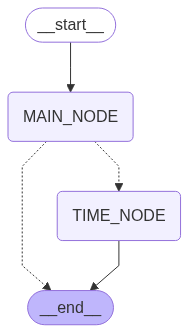

In [166]:
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node('MAIN_NODE',MAIN_NODE)
builder.add_node('TIME_NODE',TIME_NODE)

builder.add_edge(START, 'MAIN_NODE')
builder.add_conditional_edges('MAIN_NODE', MCP_TOOL_EDGE)

checkpointer = InMemorySaver()

grah = builder.compile(checkpointer=checkpointer)

display(Image(grah.get_graph().draw_mermaid_png()))

In [168]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
for state in grah.stream({template},config=config, stream_mode="updates"):
    print(state)

{'MAIN_NODE': {'messages': AIMessage(content="The current time in **Europe/London** is **12:46 AM (BST, with Daylight Saving Time active)**, and in **Asia/Tokyo**, it's **8:46 AM (JST, without Daylight Saving Time)**. \n\nLet me know if you need help converting times or anything else! 😊", additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-28T23:49:26.448834119Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8999925193, 'load_duration': 96105405, 'prompt_eval_count': 379, 'prompt_eval_duration': 331640803, 'eval_count': 409, 'eval_duration': 8540072974, 'model_name': 'qwen3:14b'}, id='run--686c31d7-9b71-4ce8-b91c-d94dbdfe4fe8-0', usage_metadata={'input_tokens': 379, 'output_tokens': 409, 'total_tokens': 788})}}


In [173]:
ss = grah.get_state(config=config)

for msg in ss.values['messages']:
    msg.pretty_print()

================================ Human Message =================================

How are you today?
================================== Ai Message ==================================

I'm just a humble AI assistant, but I'm here and ready to help you with whatever you need! How can I assist you today? 😊
================================ Human Message =================================

What time is on 'Europe/London' and on Asia/Tokyo
================================== Ai Message ==================================
Tool Calls:
  get_current_time (0d91d68f-ed9d-478c-9aac-f1e9b00b1036)
 Call ID: 0d91d68f-ed9d-478c-9aac-f1e9b00b1036
  Args:
    timezone: Europe/London
  get_current_time (d3b99c8d-7017-4d0b-9af8-067ce5b4be5d)
 Call ID: d3b99c8d-7017-4d0b-9af8-067ce5b4be5d
  Args:
    timezone: Asia/Tokyo
================================= Tool Message =================================
Name: get_current_time

{
  "timezone": "Europe/London",
  "datetime": "2025-06-29T00:46:43+01:00",
  "is_dst":

In [167]:
checkpointer.delete_thread("1")

In [ ]:
HumanMessage.pretty_print

In [118]:
def get_all_links(url:str, timeout:float = 5.0) -> list[str] | None:
    """
    Fetch all the html links from a provided url

    Args:
        url: The url from were all links are extracted
    """

    response = requests.get(url, timeout=timeout)

    if response.status_code != 200:
        print(f'got code: {response.status_code}')
        return None

    splitted_url = test_utl.split('/')

    protocol = splitted_url[0]

    basesite = splitted_url[2]


    soup = BeautifulSoup(response.text,"lxml")

    urls = []

    for link in soup.find_all('a', href=True):
               
        url = link['href']

        if 'http' in url:
            if not basesite in url:
                continue

        url = url.split(basesite)[-1]
        
        if url == '':
            continue

        if url[0] == '#':
            continue

        url = url.split('#')[0]
        url = url.split('?')[0]

        if ':' in url:
            continue

        if url[0] != '/':
            url = '/' + url

        full_url = protocol + '//' + basesite + url

        if full_url not in urls:
            urls.append(full_url)

    return urls

In [124]:
#test_utl='https://www.cpm.coop/mapa-de-sitio'
#test_utl = 'https://www.hsbc.com.mx/mapa-de-sitio/'
test_utl = 'https://www.bbva.mx/personas/mapa-del-sitio.html'
#test_utl = 'https://www.banamex.com/es/mapa-del-sitio.html'

In [125]:
a = get_all_links(test_utl)
a

['https://www.bbva.mx/',
 'https://www.bbva.mx/empresas.html',
 'https://www.bbva.mx/pyme.html',
 'https://www.bbva.mx/personas/hazte-cliente.html',
 'https://www.bbva.mx/personas.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-azul.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-oro.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-platinum.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-vive.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-rayados.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-educacion.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-ipn.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-afinidad-un